# Machine Learning Test

You have 3 days to solve the test from the moment you receive it. 

Show us your skills !

## Problem description

You are hired as a Data Scientist at a top real state company in California, and you first job is to develop an ML model to predict house prices. This model will then be used as an investment tool in your company, to buy houses when their price is lower than their real value or negotiating overprices.

## Get the data

Over the years, your company has been gathering some data that you can start using. It is available in the following link: https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/housing.tgz

## Imports

In [30]:
# Data Analysis
import pandas as pd
import numpy as np
import math

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Model training and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score

#Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor ,RANSACRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

# Ignore noise warning
import warnings
warnings.filterwarnings('ignore')

# Work with pickles
import pickle as pkl

pd.set_option('display.max_column', None)

## Explore the data

Load the data to explore it. Try to answer the following questions:

- How many features has the dataset ? What type are they ?
- How many samples are in the dataset ? 
- Are there missing values ? 
- Is there any correlation between features ?

In [31]:
housing_df = pd.read_csv('data/housing.csv')
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### How many features has the dataset? What type are they?

In [32]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### How many samples are in the dataset? 

In [33]:
housing_df.shape

(20640, 10)

### Are there missing values?

In [34]:
housing_df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

### Let's check if there are duplicated values and outliers

In [35]:
housing_df.duplicated().sum()

0

In [36]:
stats = housing_df.describe().transpose()
stats["IQR"] = stats["75%"] - stats["25%"]
outliers = pd.DataFrame(columns=housing_df.columns)
for col in stats.index:
    iqr = stats.at[col, 'IQR']
    cutoff = iqr * 1.5
    lower = stats.at[col, '25%'] - cutoff
    upper = stats.at[col, '75%'] + cutoff
    results = housing_df[(housing_df[col] < lower) | (housing_df[col] > upper)].copy()
    results['Outlier'] = col
    outliers = outliers.append(results)
print(housing_df.shape)
print(outliers.shape)

(20640, 10)
(6726, 11)


In [37]:
print ('El', 6726/20640*100,'% de valores son outliers')

El 32.58720930232558 % de valores son outliers


### How much variablility this dataset's features have?

In [38]:
housing_df.nunique()

longitude               844
latitude                862
housing_median_age       52
total_rooms            5926
total_bedrooms         1923
population             3888
households             1815
median_income         12928
median_house_value     3842
ocean_proximity           5
dtype: int64

### Let's see some metrics statistics

In [39]:
housing_df.describe().to_csv('data/output_csv/descriptive_stats.csv')

In [40]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### Is there any correlation between features?

In [41]:
housing_df.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


## Visualize the data

Try to come up with the best possible visualizations (most informative) for the dataset.

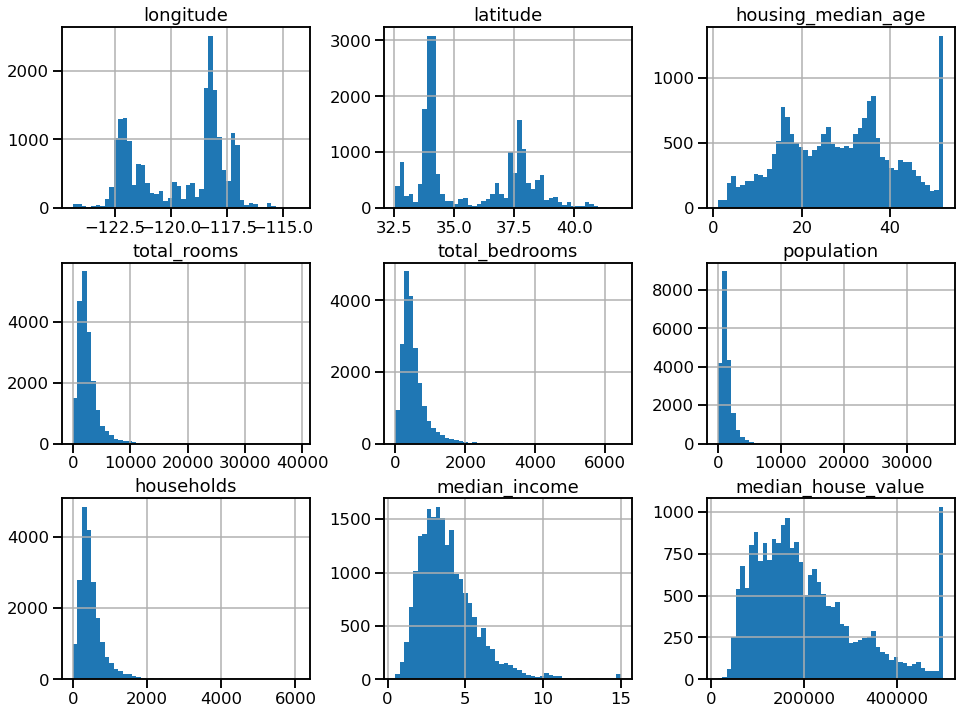

In [42]:
housing_df.hist(figsize=(16,12), bins=50)
plt.savefig('images/output_images/housing_hist.png')
sns.set_context("talk")
plt.show()

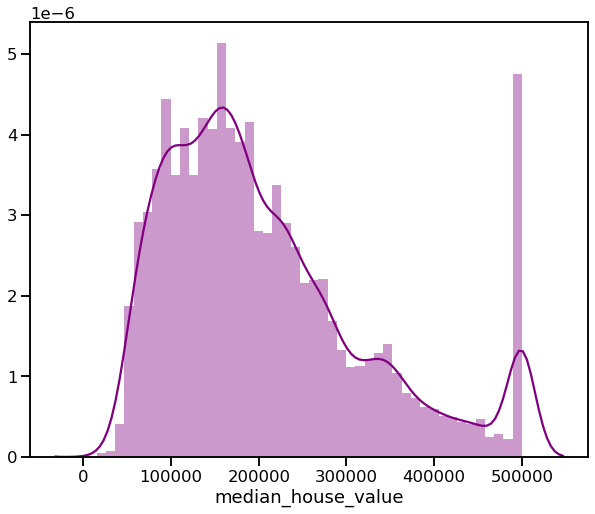

In [43]:
plt.figure(figsize=(10,8))
sns.distplot(housing_df['median_house_value'],color='purple')
plt.savefig('images/output_images/value_dist.png')
sns.set_context("talk")
plt.show()

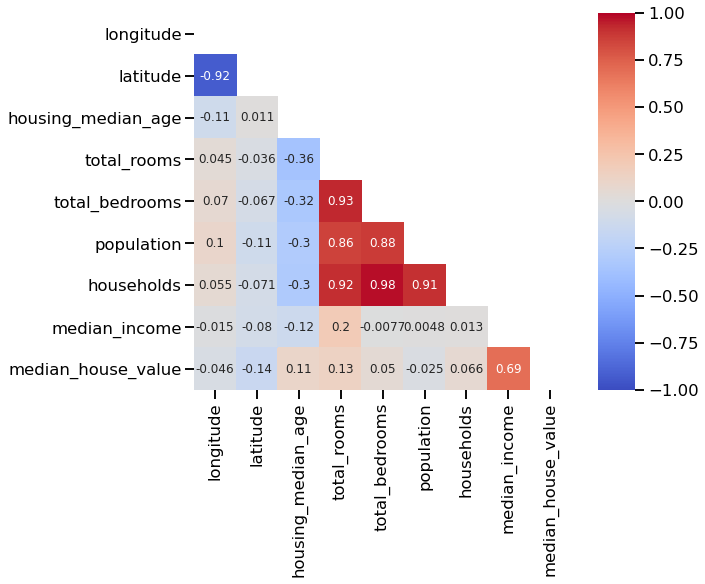

In [44]:
mask = np.triu(np.ones_like(housing_df.corr(), dtype=np.bool))
plt.figure(figsize=(16,8), constrained_layout=True)
sns.heatmap(housing_df.corr(),square=True, cmap='coolwarm', vmin=-1, vmax=1, mask=mask, annot=True, annot_kws={"size": 12}) 
plt.savefig('images/output_images/housing_corr.png')
sns.set_context("talk")
plt.show()

Las mayores correlaciones se dan entre:

* median_income y median_hause_value (igual no puedo usar el propio target)

* total_rooms y total_bedrooms, total_rooms y population, y total_rooms y households

* total_bedrooms y population, y total_bedrooms y households

* population y households

* median_income y median_hause_value (pero no la puedo usar al contener el propio target)

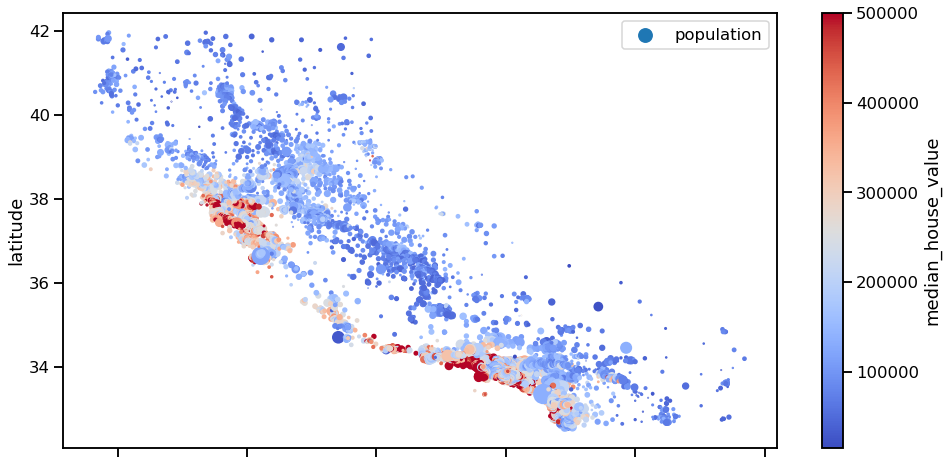

In [45]:
housing_df.plot(kind="scatter", x="longitude", y="latitude", s=housing_df["population"]/100, 
             label="population", c="median_house_value", cmap='coolwarm', colorbar=True, figsize=(16,8))
plt.savefig('images/output_images/housing_pop_per_loc.png')
sns.set_context("talk")
plt.show()

La ubicación no correlaciona mucho con el precio, pero aquí vemos como los precios en grandes urbes y cercanos a la costa (**San Francisco** y alrededores, **Los Angeles** y alrededores, así como **San Diego** y cercanías) concentran las casas de mayor valor de mercado

## Feature engineering

Try to combine several features into new ones and see if they have better correlation.

In [46]:
housing_df_newfeat = housing_df.copy()

In [47]:
housing_df_newfeat["income_per_house_val"] = housing_df_newfeat["median_income"]/housing_df_newfeat["median_house_value"]

housing_df_newfeat["rooms_per_bedroom"] = housing_df_newfeat["total_rooms"]/housing_df_newfeat["total_bedrooms"]
housing_df_newfeat["rooms_per_population"] = housing_df_newfeat["total_rooms"]/housing_df_newfeat["population"]
housing_df_newfeat["rooms_per_household"]=housing_df_newfeat["total_rooms"]/housing_df_newfeat["households"]

housing_df_newfeat["bedrooms_per_population"] = housing_df_newfeat["total_bedrooms"]/housing_df_newfeat["population"]
housing_df_newfeat["bedrooms_per_household"] = housing_df_newfeat["total_bedrooms"]/housing_df_newfeat["households"]

In [48]:
corr = housing_df_newfeat.corr()
print(corr['median_house_value'].sort_values(ascending = False))

median_house_value         1.000000
median_income              0.688075
rooms_per_bedroom          0.383920
rooms_per_population       0.209482
rooms_per_household        0.151948
total_rooms                0.134153
housing_median_age         0.105623
bedrooms_per_population    0.069896
households                 0.065843
total_bedrooms             0.049686
population                -0.024650
longitude                 -0.045967
bedrooms_per_household    -0.046739
latitude                  -0.144160
income_per_house_val      -0.518606
Name: median_house_value, dtype: float64


Mayor correlación  con target, independientemente del signo, que las predecesoras:

* rooms_per_bedroom
* rooms_per_population
* rooms_per_household
* bedrooms_per_population

Menor correlación  con target, independientemente del signo, que las predecesoras:
* population_per_household 
* bedrooms_per_household

## Prepare the data for ML algorithms

Using [Scikit-learn](https://scikit-learn.org/stable/) build a pipeline for data preparation. The pipeline should include:

- Data cleaning
- Encoding of categorical features
- Feature scaling

### Building the pipeline

In [49]:
X = housing_df_newfeat.drop(['median_house_value'], axis=1)
y = housing_df_newfeat['median_house_value']

In [50]:
numeric_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
                    'households', 'median_income', 'income_per_house_val', 'rooms_per_bedroom', 'rooms_per_population',
                    'rooms_per_household', 'bedrooms_per_population', 'bedrooms_per_household']
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), 
                                      ('scaler', StandardScaler())])

categorical_features = ['ocean_proximity']
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessing_pipeline = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                                          ('cat', categorical_transformer, categorical_features)])

In [51]:
X_prep = preprocessing_pipeline.fit_transform(X)

## Train some models

Train a list of models on default parameters to get a quick idea of the performance of each one with the dataset. Compare their performance and keep the top 3-5 models for the next step.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_prep, y, random_state=42, test_size=0.2)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

(16512, 19) (16512,) (4128, 19) (4128,)


In [24]:
def baseline_report(model, X_train, X_test, y_train, y_test, name):
    strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True)
    model.fit(X_train, y_train)
    r2_score                 = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, 
                                                       scoring='r2', n_jobs=-2))
    explained_variance_score = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, 
                                                       scoring='explained_variance', n_jobs=-2))
    neg_mean_squared_error       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, 
                                                       scoring='neg_mean_squared_error', n_jobs=-2))
    neg_root_mean_squared_error      = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, 
                                                       scoring='neg_root_mean_squared_error', n_jobs=-2))
    y_pred = model.predict(X_test)

    df_model = pd.DataFrame({'model'                       : [name],
                             'r2'                          : [r2_score],
                             'explained_variance'          : [explained_variance_score],
                             'neg_mean_squared_error'      : [neg_mean_squared_error],
                             'neg_root_mean_squared_error' : [neg_root_mean_squared_error],
                            })   
    return df_model

In [25]:
raise SystemExit("Stop right there! For computational reasons I didn't execute all models at once. If you want to do so, execute the following 2 cells, then skip 11 cells after that). I recommend to skip the following 2 cells and run the cells ofter that little by little.")

SystemExit: Stop right there! For computational reasons I didn't execute all models at once. If you want to do so, execute the following 2 cells, then skip 11 cells after that). I recommend to skip the following 2 cells and run the cells ofter that little by little.

In [ ]:
models = {'LinearRegression': LinearRegression(),
          'Ridge': Ridge(),
          'Lasso': Lasso(),
          'ElasticNet': ElasticNet(),
          'SGDRegressor': SGDRegressor(),
          'RANSACRegressor': RANSACRegressor(),
          'SVR': SVR(),
          'LinearSVR': LinearSVR(),
          'KNeighborsRegressor': KNeighborsRegressor(),
          'GaussianProcessRegressor':GaussianProcessRegressor(),
          'DecisionTreeRegressor': DecisionTreeRegressor(),
          'AdaBoostRegressor': AdaBoostRegressor(),
          'BaggingRegressor': BaggingRegressor(),
          'RandomForestRegressor': RandomForestRegressor(),
          'GradientBoostingRegressor': GradientBoostingRegressor(),
          'MLPRegressor': MLPRegressor()
         }

In [ ]:
models_df = pd.concat([baseline_report(model, X_train, X_test, y_train, y_test, name) for (name, model) in models.items()])
models_df.to_csv('data/output_csv/models_all.csv')
models_df

Continue here to train models in smaller groups. 

In [ ]:
models = {'LinearRegression': LinearRegression(),
          'Ridge': Ridge(),
          'Lasso': Lasso(),
          'ElasticNet': ElasticNet(),
          #'SGDRegressor': SGDRegressor(),
          #'RANSACRegressor': RANSACRegressor(),
          #'SVR': SVR(),
          #'LinearSVR': LinearSVR(),
          #'KNeighborsRegressor': KNeighborsRegressor(),
          #'GaussianProcessRegressor':GaussianProcessRegressor(),
          #'DecisionTreeRegressor': DecisionTreeRegressor(),
          #'AdaBoostRegressor': AdaBoostRegressor(),
          #'BaggingRegressor': BaggingRegressor(),
          #'RandomForestRegressor': RandomForestRegressor(),
          #'GradientBoostingRegressor': GradientBoostingRegressor(),
          #'MLPRegressor': MLPRegressor()
         }

In [ ]:
models_df1 = pd.concat([baseline_report(model, X_train, X_test, y_train, y_test, name) for (name, model) in models.items()])
models_df1.to_csv('data/output_csv/models_first.csv')
models_df1

In [ ]:
models = {#'LinearRegression': LinearRegression(),
          #'Ridge': Ridge(),
          #'Lasso': Lasso(),
          #'ElasticNet': ElasticNet(),
          'SGDRegressor': SGDRegressor(),
          'RANSACRegressor': RANSACRegressor(),
          'SVR': SVR(),
          'LinearSVR': LinearSVR(),
          #'KNeighborsRegressor': KNeighborsRegressor(),
          #'GaussianProcessRegressor':GaussianProcessRegressor(),
          #'DecisionTreeRegressor': DecisionTreeRegressor(),
          #'AdaBoostRegressor': AdaBoostRegressor(),
          #'BaggingRegressor': BaggingRegressor(),
          #'RandomForestRegressor': RandomForestRegressor(),
          #'GradientBoostingRegressor': GradientBoostingRegressor(),
          #'MLPRegressor': MLPRegressor()
         }

In [ ]:
models_df2 = pd.concat([baseline_report(model, X_train, X_test, y_train, y_test, name) for (name, model) in models.items()])
models_df2.to_csv('data/output_csv/models_second.csv')
models_df2

In [ ]:
models = {#'LinearRegression': LinearRegression(),
          #'Ridge': Ridge(),
          #'Lasso': Lasso(),
          #'ElasticNet': ElasticNet(),
          #'SGDRegressor': SGDRegressor(),
          #'RANSACRegressor': RANSACRegressor(),
          #'SVR': SVR(),
          #'LinearSVR': LinearSVR(),
          'KNeighborsRegressor': KNeighborsRegressor(),
          'GaussianProcessRegressor':GaussianProcessRegressor(),
          'DecisionTreeRegressor': DecisionTreeRegressor(),
          'AdaBoostRegressor': AdaBoostRegressor(),
          #'BaggingRegressor': BaggingRegressor(),
          #'RandomForestRegressor': RandomForestRegressor(),
          #'GradientBoostingRegressor': GradientBoostingRegressor(),
          #'MLPRegressor': MLPRegressor()
         }

In [ ]:
models_df3 = pd.concat([baseline_report(model, X_train, X_test, y_train, y_test, name) for (name, model) in models.items()])
models_df3.to_csv('data/output_csv/models_third.csv')
models_df3

In [ ]:
models = {#'LinearRegression': LinearRegression(),
          #'Ridge': Ridge(),
          #'Lasso': Lasso(),
          #'ElasticNet': ElasticNet(),
          #'SGDRegressor': SGDRegressor(),
          #'RANSACRegressor': RANSACRegressor(),
          #'SVR': SVR(),
          #'LinearSVR': LinearSVR(),
          #'KNeighborsRegressor': KNeighborsRegressor(),
          #'GaussianProcessRegressor':GaussianProcessRegressor(),
          #'DecisionTreeRegressor': DecisionTreeRegressor(),
          #'AdaBoostRegressor': AdaBoostRegressor(),
          'BaggingRegressor': BaggingRegressor(),
          'RandomForestRegressor': RandomForestRegressor(),
          #'GradientBoostingRegressor': GradientBoostingRegressor(),
          #'MLPRegressor': MLPRegressor()
         }

In [ ]:
models_df4 = pd.concat([baseline_report(model, X_train, X_test, y_train, y_test, name) for (name, model) in models.items()])
models_df4.to_csv('data/output_csv/models_fourth.csv')
models_df4

In [ ]:
models = {#'LinearRegression': LinearRegression(),
          #'Ridge': Ridge(),
          #'Lasso': Lasso(),
          #'ElasticNet': ElasticNet(),
          #'SGDRegressor': SGDRegressor(),
          #'RANSACRegressor': RANSACRegressor(),
          #'SVR': SVR(),
          #'LinearSVR': LinearSVR(),
          #'KNeighborsRegressor': KNeighborsRegressor(),
          #'GaussianProcessRegressor':GaussianProcessRegressor(),
          #'DecisionTreeRegressor': DecisionTreeRegressor(),
          #'AdaBoostRegressor': AdaBoostRegressor(),
          #'BaggingRegressor': BaggingRegressor(),
          #'RandomForestRegressor': RandomForestRegressor(),
          'GradientBoostingRegressor': GradientBoostingRegressor(),
          'MLPRegressor': MLPRegressor()
         }

In [ ]:
models_df5 = pd.concat([baseline_report(model, X_train, X_test, y_train, y_test, name) for (name, model) in models.items()])
models_df5.to_csv('data/output_csv/models_fourth.csv')
models_df5

In [ ]:
models_df = pd.concat([models_df1, models_df2, models_df3, models_df4, models_df5])
models_df.to_csv('data/output_csv/models_all.csv')
models_df

Teniendo en cuenta que R^2 y variancia explicada son óptimas cuando se acercan a 1, y que ambas medidas de error lo son cuanto mas se acercquen a 0; las mejores modelos son RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, DecisionTreeRegressor, y KNeighborsRegressor. 
Estos 5 modelos conforman el top 5 de valores en las métricas a excepción de para el error cuadrático medio que no es coherente con la dirección en la que apuntan los valores para las métricas restantes.

## Fine-tune best models

Use Scitkit-learn random search hyperparameter tuning to find the best hyperparameters for the best models selected in the previus step.

### RandomForestRegressor

#### RandomizedSearchCV

In [ ]:
random_forest = RandomForestRegressor(random_state = 42)

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
n_estimators.append(list(np.arange(50,200)))

param_grid =  {'criterion': ['mse', 'mae'],
               'max_depth': max_depth, 
               'max_features': ['auto', 'sqrt', 'log2'],
               'n_estimators' : n_estimators,
               'min_samples_leaf': np.arange(1,20),
               'min_samples_split': np.arange(2,25),
               'bootstrap': [True, False],
               'oob_score': [True, False] 
            }

randomized = RandomizedSearchCV(random_forest, param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1, refit=True)

randomized.fit(X_train, y_train)

randomized.best_estimator_

print(randomized.best_params_)

In [ ]:
ramdomized_RFR = pd.DataFrame(randomized.cv_results_)
ramdomized_RFR.to_csv('data/output_csv/randomized_RFR.csv')
ramdomized_RFR.sort_values(by='rank_test_score', axis=0).head()

#### GridSearchCV

In [ ]:
random_forest = RandomForestRegressor(random_state = 42)

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
n_estimators.append(list(np.arange(50,200)))

param_grid =  {'criterion': ['mse', 'mae'],
               'max_depth': max_depth, 
               'max_features': ['auto', 'sqrt', 'log2'],
               'n_estimators' : n_estimators,
               'min_samples_leaf': np.arange(1,20),
               'min_samples_split': np.arange(2,25),
               'bootstrap': [True, False],
               'oob_score': [True, False] 
            }

grid = GridSearchCV(random_forest, param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1, refit=True)

grid.fit(X_train, y_train)

grid.best_estimator_

print(grid.best_params_)

In [ ]:
grid_RFR = pd.DataFrame(randomized.cv_results_)
grid_RFR.to_csv('data/output_csv/grid_RFR.csv')
grid_RFR.sort_values(by='rank_test_score', axis=0).head()

### BaggingRegressor

#### RandomizedSearchCV

In [ ]:
bagging = BaggingRegressor(random_state = 42)


n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
n_estimators.append(list(np.arange(50,200)))

param_grid =  {'base_estimator': [KNeighborsRegressor(), None],
               'max_features': [0.25, 0.5, 0.75, 1.0],
               'n_estimators' : n_estimators,
               'bootstrap_features': [True, False],
               'bootstrap': [True, False],
               'oob_score': [True, False] 
            }

randomized = RandomizedSearchCV(bagging, param_grid, cv=3, scoring='r2', verbose=2, n_jobs=2, refit=True)

randomized.fit(X_train, y_train)

randomized.best_estimator_

print(randomized.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.


In [ ]:
randomized_BR = pd.DataFrame(randomized.cv_results_)
randomized_BR.to_csv('data/output_csv/randomized_BR.csv')
randomized_BR.sort_values(by='rank_test_score', axis=0).head()

#### GridSearchCV

In [ ]:
bagging = BaggingRegressor(random_state = 42)

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
n_estimators.append(list(np.arange(50,200)))

param_grid =  {'base_estimator': [KNeighborsRegressor(), None],
               'max_features': [0.25, 0.5, 0.75, 1.0],
               'n_estimators' : n_estimators,
               'bootstrap_features': [True, False],
               'bootstrap': [True, False],
               'oob_score': [True, False] 
            }

grid = GridSearchCV(bagging, param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1, refit=True)

grid.fit(X_train, y_train)

grid.best_estimator_

print(grid.best_params_)

In [ ]:
grid_BR = pd.DataFrame(grid.cv_results_)
grid_BR.to_csv('data/output_csv/grid_BR.csv')
grid_BR.sort_values(by='rank_test_score', axis=0).head()

### GradientBoostingRegressor

#### RandomizedSearchCV

In [25]:
gradient_booster = GradientBoostingRegressor(random_state = 42)

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
n_estimators.append(list(np.arange(50,200)))

param_grid =  {'loss':['ls', 'lad', 'huber', 'quantile'],
               'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
               'max_depth': max_depth, 
               'n_estimators' : n_estimators,
               'min_samples_leaf': np.arange(1,20),
               'min_samples_split': np.arange(2,25),
               'max_features':['auto', 'sqrt', 'log2'],
               'criterion': ['friedman_mse', 'mse', 'mae'],
               'subsample':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
              }

randomized = RandomizedSearchCV(gradient_booster, param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1, refit=True)

randomized.fit(X_train, y_train)

randomized.best_estimator_

print(randomized.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: 

In [ ]:
randomized_GBR = pd.DataFrame(randomized.cv_results_)
randomized_GBR.to_csv('data/output_csv/randomized_GBR.csv')
randomized_GBR.sort_values(by='rank_test_score', axis=0).head()

#### GridSearchCV

In [ ]:
gradient_booster = GradientBoostingRegressor(random_state = 42)

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
n_estimators.append(list(np.arange(50,200)))

param_grid =  {'loss':['ls', 'lad', 'huber', 'quantile'],
               'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
               'max_depth': max_depth, 
               'n_estimators' : n_estimators,
               'min_samples_leaf': np.arange(1,20),
               'min_samples_split': np.arange(2,25),
               'max_features':['auto', 'sqrt', 'log2'],
               'criterion': ['friedman_mse', 'mse', 'mae'],
               'subsample':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
              }

grid = GridSearchCV(gradient_booster, param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1, refit=True)

grid.fit(X_train, y_train)

grid.best_estimator_

print(grid.best_params_)

In [ ]:
grid_GBR = pd.DataFrame(grid.cv_results_)
grid_GBR.to_csv('data/output_csv/grid_GBR.csv')
grid_GBR.sort_values(by='rank_test_score', axis=0).head()

### DecisionTreeRegressor

#### RandomizedSearchCV

In [56]:
decision_tree = DecisionTreeRegressor(random_state = 42)

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

param_grid =  {'criterion': ['mse', 'mae', 'friedman_mse'],
               'max_depth': max_depth, 
               'max_features': ['auto', 'sqrt', 'log2'],
               'min_samples_leaf': np.arange(1,20),
               'min_samples_split': np.arange(2,25),
               }

randomized = RandomizedSearchCV(decision_tree, param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1, refit=True)

randomized.fit(X_train, y_train)

randomized.best_estimator_

print(randomized.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: 

In [ ]:
randomized_DTR = pd.DataFrame(randomized.cv_results_)
randomized_DTR.to_csv('data/output_csv/randomized_DTR.csv')
randomized_DTR.sort_values(by='rank_test_score', axis=0).head()

#### GridSearchCV

In [ ]:
decision_tree = DecisionTreeRegressor(random_state = 42)

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

param_grid =  {'criterion': ['mse', 'mae', 'friedman_mse'],
               'max_depth': max_depth, 
               'max_features': ['auto', 'sqrt', 'log2'],
               'min_samples_leaf': np.arange(1,20),
               'min_samples_split': np.arange(2,25),
               }

grid = GridSearchCV(decision_tree, param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1, refit=True)

grid.fit(X_train, y_train)
 
grid.best_estimator_

print(grid.best_params_)

In [ ]:
grid_DTR = pd.DataFrame(grid.cv_results_)
grid_DTR.to_csv('data/output_csv/grid_DTR.csv')
grid_DTR.sort_values(by='rank_test_score', axis=0).head()

### KNeighborsRegressor

#### RandomizedSearchCV

In [60]:
kn_regressor = KNeighborsRegressor()

n_neighbors = [int(x) for x in np.linspace(2, 20, num = 10)]

leaf_size = [int(x) for x in np.linspace(10, 100, num = 10)]

param_grid =  {'weights': ['uniform', 'distance'],
               'n_neighbors': n_neighbors, 
               'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
               'metric' : ['euclidean', 'manhattan'],
               'leaf_size': leaf_size,
            }

randomized = RandomizedSearchCV(kn_regressor, param_grid, cv=5, scoring='r2', verbose=2, n_jobs=-1, refit=True)

randomized.fit(X_train, y_train)

randomized.best_estimator_

print(randomized.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   18.7s


{'weights': 'distance', 'n_neighbors': 10, 'metric': 'euclidean', 'leaf_size': 50, 'algorithm': 'kd_tree'}


[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   24.2s finished


In [67]:
randomized_KNR.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_weights', 'param_n_neighbors', 'param_metric', 'param_leaf_size',
       'param_algorithm', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

In [79]:
randomized_KNR = pd.DataFrame(randomized.cv_results_)
randomized_KNR.to_csv('data/output_csv/randomized_KNR.csv')
randomized_KNR.sort_values(by='rank_test_score', axis=0).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_weights,param_n_neighbors,param_metric,param_leaf_size,param_algorithm,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,0.068821,0.002594,0.561694,0.041393,distance,10,euclidean,50,kd_tree,"{'weights': 'distance', 'n_neighbors': 10, 'me...",0.897769,0.897023,0.900171,0.906943,0.898506,0.900082,0.003585,1
6,0.068417,0.002325,0.504452,0.034335,uniform,6,euclidean,60,kd_tree,"{'weights': 'uniform', 'n_neighbors': 6, 'metr...",0.894224,0.894222,0.900908,0.904509,0.898368,0.898446,0.003962,2
4,0.035713,0.000742,1.314293,0.133004,distance,14,euclidean,100,ball_tree,"{'weights': 'distance', 'n_neighbors': 14, 'me...",0.893759,0.893914,0.896054,0.903749,0.894413,0.896378,0.003774,3
1,0.059634,0.004254,0.586045,0.035189,uniform,18,euclidean,70,kd_tree,"{'weights': 'uniform', 'n_neighbors': 18, 'met...",0.886221,0.884748,0.887035,0.896227,0.884977,0.887842,0.004275,4
9,0.003989,0.000631,0.898397,0.037865,uniform,18,euclidean,80,brute,"{'weights': 'uniform', 'n_neighbors': 18, 'met...",0.886221,0.884748,0.887035,0.896227,0.884977,0.887842,0.004275,4


#### GridSearchCV

In [86]:
kn_regressor = KNeighborsRegressor()

param_grid =  {'weights': ['uniform', 'distance'],
               'n_neighbors': [10, 6, 14, 4], 
               'algorithm': ['auto', 'ball_tree', 'kd_tree'],
               'metric' : ['euclidean'],
               'leaf_size': [50, 60, 100, 80],
            }

grid = GridSearchCV(kn_regressor, param_grid, cv=5, scoring='r2', verbose=2, n_jobs=-2, refit=True)

grid.fit(X_train, y_train)

grid.best_estimator_

print(grid.best_params_)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-2)]: Done 156 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-2)]: Done 359 tasks      | elapsed:  2.3min


{'algorithm': 'auto', 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'distance'}


[Parallel(n_jobs=-2)]: Done 640 out of 640 | elapsed:  3.7min finished


In [85]:
grid_KNR = pd.DataFrame(grid.cv_results_)
grid_KNR.to_csv('data/output_csv/grid_KNR.csv')
grid_KNR.sort_values(by='rank_test_score', axis=0).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_weights,param_n_neighbors,param_metric,param_leaf_size,param_algorithm,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,0.071812,0.004545,0.664418,0.053456,distance,10,euclidean,50,kd_tree,"{'weights': 'distance', 'n_neighbors': 10, 'me...",0.897769,0.897023,0.900171,0.906943,0.898506,0.900082,0.003585,1
9,0.061646,0.002317,0.581852,0.018716,distance,10,euclidean,80,auto,"{'weights': 'distance', 'n_neighbors': 10, 'me...",0.897769,0.897023,0.900171,0.906943,0.898506,0.900082,0.003585,1
3,0.062238,0.001623,0.554917,0.032689,uniform,6,euclidean,80,kd_tree,"{'weights': 'uniform', 'n_neighbors': 6, 'metr...",0.894224,0.894222,0.900908,0.904509,0.898368,0.898446,0.003962,3
8,0.003989,0.000631,1.078117,0.070890,uniform,6,euclidean,80,brute,"{'weights': 'uniform', 'n_neighbors': 6, 'metr...",0.894224,0.894222,0.900908,0.904509,0.898368,0.898446,0.003962,3
2,0.039693,0.001466,1.625865,0.100450,uniform,4,euclidean,100,ball_tree,"{'weights': 'uniform', 'n_neighbors': 4, 'metr...",0.895609,0.894491,0.897877,0.903714,0.896976,0.897733,0.003206,5


## Build an ensamble

Build an ensamble with the best fine-tuned models and evaluate its performance.

In [ ]:
# build an ensamble

## Optional

For extra points try to:

- Implement custom transformers for feature selection and feature engineering.
- Include the data preparation and custom transformers in the fine-tuning pipeline to come up with the best set of features and data preparation strategies.
- Perform error analysis to select the models that make the most diverse type of errors for the ensambling.
- Do anything that teach us something new !

In [ ]:
# show your skills !